# Train Q on a LQR environment

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 0
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
greedy_key, key = jax.random.split(key)
shuffle_key, key = jax.random.split(key)
q_network_key, key = jax.random.split(key)
random_weights_key, key = jax.random.split(key)
pbo_network_key, key = jax.random.split(key)
training_q_key, key = jax.random.split(key)

# Box over states and actions
max_discrete_state = 7
n_discrete_states = 5
max_discrete_action = 9
n_discrete_actions = 7

gamma = 1

# Sample collection
n_samples = 1000
epsilon_greedy = 0.3
max_episode_length = 4

# Q function
layer_dimension = 50
random_weights_range = 1
action_range_on_max = 2 * max_discrete_action
n_actions_on_max = 1000

# Q trainings
max_iterations = 10000
batch_size_q = 1
learning_rate_q = 0.001

# PBO trainings
n_iterations = 10000
batch_size_pbo = 1
learning_rate_pbo = 0.0001

# Visualisation
plot_freq = 200
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.549325704574585s + -0.45467472076416016a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.9906147718429565s² + -0.9631714820861816a² + 0.897592306137085sa


## Collect samples

### Epsilon greedy from optimal actions

In [3]:
# from pbo.data_collection.replay_buffer import ReplayBuffer


# replay_buffer = ReplayBuffer()

# state = env.reset()
# idx_sample = 0
# epidose_length = 0

# while idx_sample < n_samples:
#     greedy_key, key = jax.random.split(greedy_key)
#     if jax.random.uniform(key) < epsilon_greedy:
#        action = env.optimal_action()
#     else:
#         greedy_key, key = jax.random.split(greedy_key)
#         action = jax.random.uniform(key, [env.B.shape[0]], minval=discrete_actions[0], maxval=discrete_actions[-1])
#     next_state, reward, _, _ = env.step(action)

#     replay_buffer.add(state, action, reward, next_state)

#     epidose_length += 1
#     idx_sample += 1

#     if epidose_length >= max_episode_length:
#         state = env.reset()
#         epidose_length = 0
#     else:    
#         state = next_state

### Samples on the crosses of the box

In [4]:
import jax.numpy as jnp

from pbo.data_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

## Visualize samples

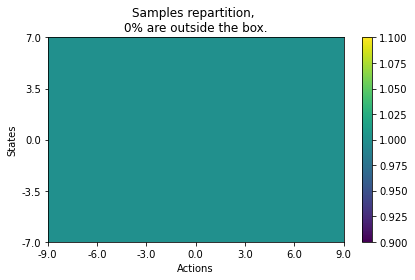

In [5]:
from pbo.data_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

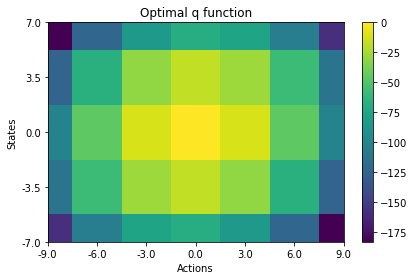

In [6]:
import pandas as pd
from pbo.utils.compute_Q_lqr import compute_Q_lqr


optimal_q = compute_Q_lqr(env, discrete_states, discrete_actions, gamma)
optimal_q_pd = pd.DataFrame(optimal_q, index=discrete_states, columns=discrete_actions)

q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network and its dataloader

In [7]:
from pbo.networks.jax.q import FullyConnectedQ
from pbo.data_collection.dataloader import DataLoader


q = FullyConnectedQ(
    layer_dimension=layer_dimension,
    network_key=q_network_key,
    random_weights_range=random_weights_range,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

replay_buffer.cast_to_jax_array()
data_loader = DataLoader(replay_buffer, batch_size_q, shuffle_key)

## Train Q 
Objective: See if the representation power of the network of Q is powerful enough to represent the optimal Q

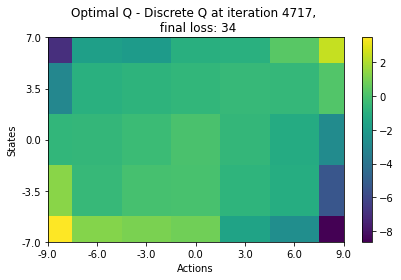

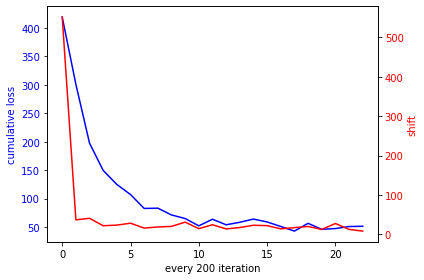

In [8]:
import matplotlib.pyplot as plt

import optax
import jax.numpy as jnp


optimizer = optax.sgd(learning_rate=learning_rate_q)
optimizer_state = optimizer.init(q.params)

# For visualization
former_discrete_q = q.discretize(q.params, discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")

while cumulative_loss > n_discrete_states * n_discrete_actions and iteration < max_iterations:
    cumulative_loss = 0

    data_loader.shuffle()
    for batch in data_loader:
        # the target is the optimal Q
        target = jnp.diag(optimal_q_pd.loc[batch["state"].flatten(), batch["action"].flatten()].values).reshape(-1, 1)

        loss, grad_loss = q.l1_loss_and_grad(q.params, batch["state"], batch["action"], target)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        q.params = optax.apply_updates(q.params, updates)

        cumulative_loss += loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        discrete_q = q.discretize(q.params, discrete_states, discrete_actions)
        shift = np.linalg.norm(discrete_q - former_discrete_q)
        
        q_visu_mesh.set_values(optimal_q - discrete_q)
        q_visu_mesh.show(f"Optimal Q - Discrete Q at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {np.around(shift, 2)}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        former_discrete_q = discrete_q

good_q_params = q.params

final_discrete_q = q.discretize(q.params, discrete_states, discrete_actions)
q_visu_mesh.set_values(optimal_q - final_discrete_q)
q_visu_mesh.show(f"Optimal Q - Discrete Q at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

# Plot the shifts and the loss
fig, ax1 = plt.subplots()

ax1.set_xlabel(f"every {plot_freq} iteration")
ax1.set_ylabel("cumulative loss", color="blue")
ax1.plot(np.arange(len(cumulative_losses)), cumulative_losses, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("shift", color="red")
ax2.plot(np.arange(len(shifts)), shifts, color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Maximizing Q over actions

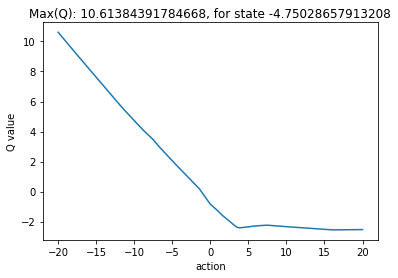

In [9]:
# random_q_params = q.to_params(q.random_weights())
random_q_params = q.to_params(q.random_init_weights())
random_state = jnp.array([np.random.uniform(-max_discrete_state, max_discrete_state)])

discrete_actions_on_max = jnp.linspace(
    -20, 20, num=10000
).reshape((-1, 1))

q_values = q.network.apply(
    random_q_params, random_state.repeat(len(discrete_actions_on_max)).reshape((-1, 1)), discrete_actions_on_max
)

plt.plot(discrete_actions_on_max, q_values)
plt.xlabel("action")
plt.ylabel("Q value")
_ = plt.title(f"Max(Q): {q_values.max()}, for state {random_state[0]}")

- Q is not spiky so discretizing the action space should work
- Taking random init weights gives smaller maximums than taking random weights